In [1]:
import pandas as pd
import scipy as sp
import pickle
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matrixprofile import *
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from random import randrange
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn.decomposition import PCA
sns.set(rc={'figure.figsize':(20.7,8.27)})

2.8284271247461903


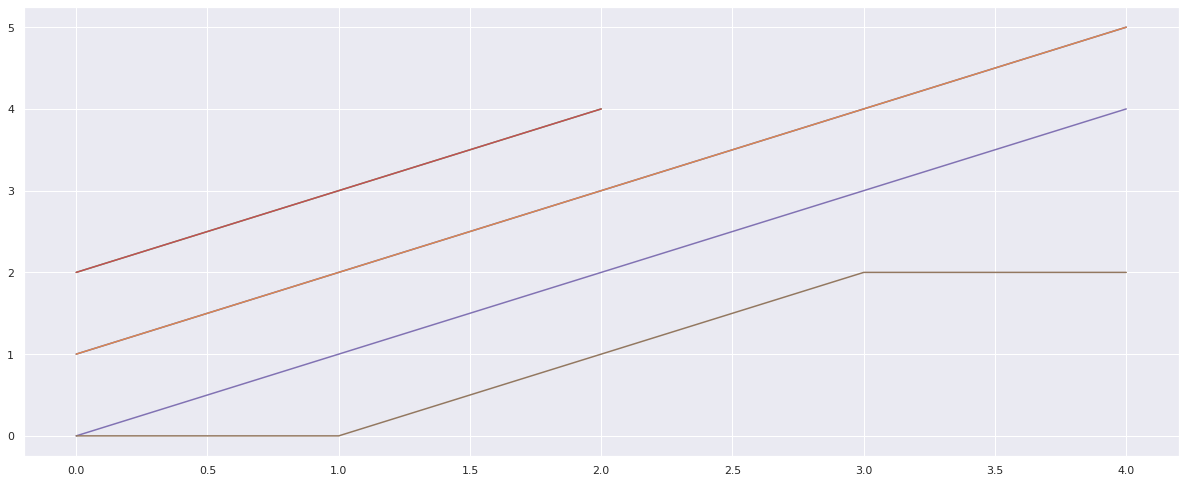

In [2]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])
distance, path = fastdtw(x, y, dist=euclidean)
print(distance)
plt.plot(x)
plt.plot(y)
plt.plot(path)

            price
90000    57.00000
90001    57.79999
90002    57.80000
90003    57.80000
90004    57.79998
...           ...
150865  119.88989
150866  119.80000
150867  119.75000
150868  119.79999
150869  119.75000

[60870 rows x 1 columns]


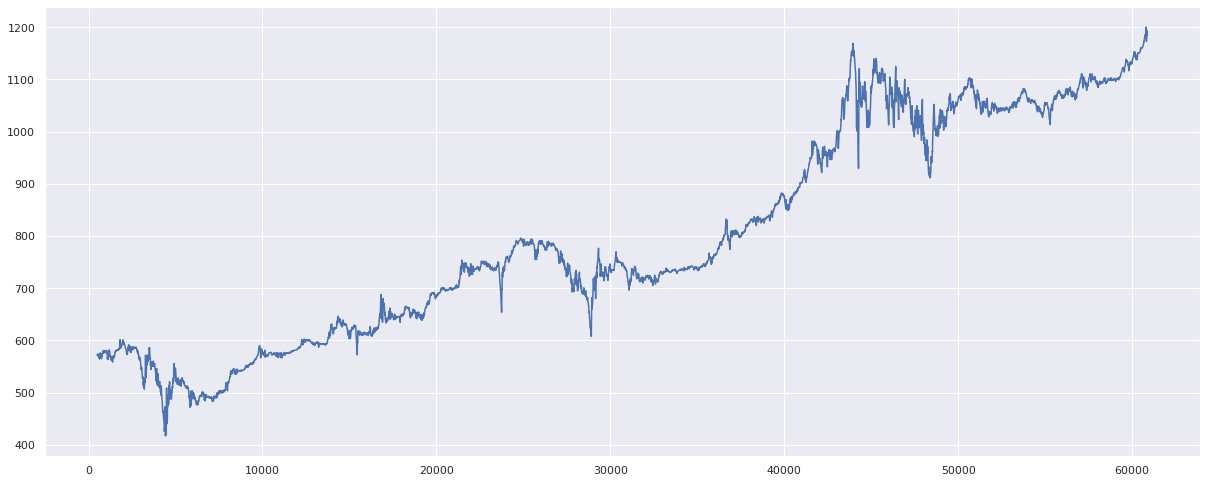

In [14]:
#Dataset https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs
#df = pd.read_csv('price-volume-data-for-all-us-stocks-etfs/Stocks/btc_hist.csv', sep=",", header=0).iloc[:-1000]
df = pd.read_csv('price-volume-data-for-all-us-stocks-etfs/Stocks/btc24EUR.csv'
                 , sep=",", header=0).iloc[90000:-90000]
column = ['3.88']
df = df.rename(columns={"1336575267": "time", "3.88": "price"})
column = ['price']
#print(df[column])
#df[column] = df[column].str.replace(',','')
#df[column] = df[column].astype(float)
#df[column] = df[column].str.replace(',','')
print(df[column])
#Denoising
df[column] = df[column].rolling(480, min_periods=1, win_type='gaussian').sum(std=4)[500:]
plt.plot(df[column].values)

In [15]:
scaler = preprocessing.MinMaxScaler()
print(df)
scaler.fit(df[column].values)
df_normalized = pd.DataFrame(scaler.transform(df[column].values)).dropna().reset_index(drop=True)
df.dropna(inplace=True)
print(df[column])

              time        price          3
90000   1363903953          NaN  17.455029
90001   1363903990          NaN   0.272577
90002   1363903990          NaN   1.731000
90003   1363903990          NaN   2.001821
90004   1363903999          NaN   1.791504
...            ...          ...        ...
150865  1365343007  1188.084990   0.944384
150866  1365343007  1188.049561   0.435988
150867  1365343111  1188.231566   4.749500
150868  1365343111  1188.632898   3.599728
150869  1365343138  1189.216467   1.997600

[60870 rows x 3 columns]
              price
90500    570.872246
90501    570.980559
90502    571.110142
90503    571.255862
90504    571.415133
...             ...
150865  1188.084990
150866  1188.049561
150867  1188.231566
150868  1188.632898
150869  1189.216467

[60370 rows x 1 columns]


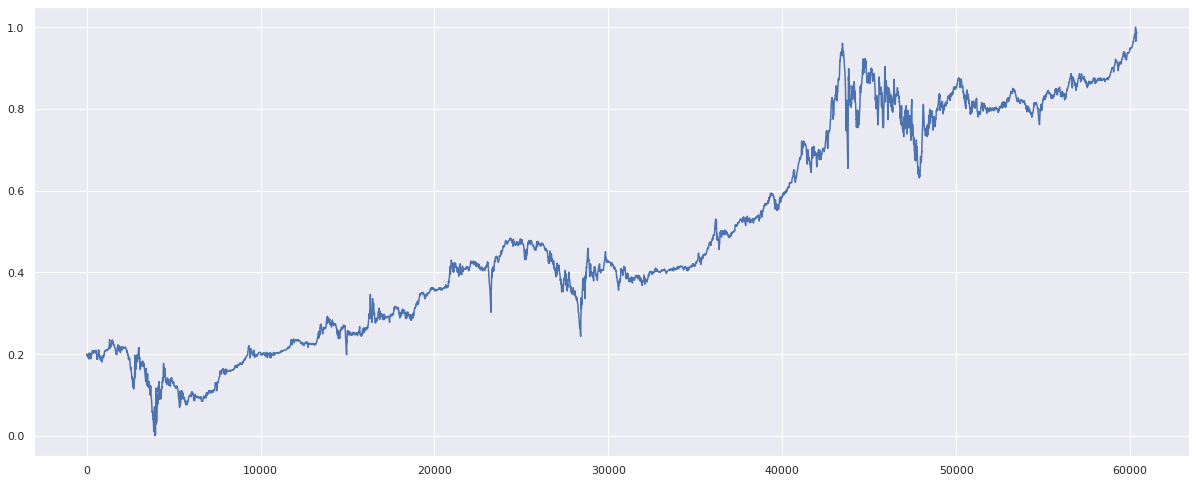

In [16]:
plt.plot(df_normalized)
plt.show()

#plt.plot(df_normalized_diff)

In [17]:
#Generate labels:
#TODO: Think about new labeling strategy
paa_length = 24
sensitivity = 7
labels = []
for i in range(0, len(df_normalized.values.T[0])-paa_length, paa_length):
    epsilon = df_normalized.values.T[0][i:i+paa_length].std()*sensitivity
    mean_old = df_normalized.values.T[0][i:i+paa_length].mean()
    mean_new = df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()
    
    if (mean_old + epsilon*0.75 <  mean_new):
        labels += [5.0] * paa_length #rise
    elif (mean_old + epsilon*0.5 < 
    df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()):
        labels += [4.0] * paa_length #rise
    elif (mean_old + epsilon*0.375 < 
    df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()):
        labels += [3.0] * paa_length #rise
    elif (mean_old+ epsilon*0.25 < 
    df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()):
        labels += [2.0] * paa_length #rise
    elif (mean_old + epsilon*0.125 < 
    df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()):
        labels += [1.0] * paa_length #rise
    elif (mean_old - epsilon*0.75 > 
    df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()):
        labels += [-1.0] * paa_length #fall
    elif (mean_old - epsilon*0.5 > 
    df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()):
        labels += [-2.0] * paa_length #fall
    elif (mean_old - epsilon*0.375 > 
    df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()):
        labels += [-3.0] * paa_length #fall
    elif (mean_old - epsilon*0.25 > 
    df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()):
        labels += [-4.0] * paa_length #fall
    elif (mean_old - epsilon*0.125 > 
    df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()):
        labels += [-5.0] * paa_length #fall
    else:
        labels += [0.0] * paa_length #equal
    
    '''
    if df_normalized.values.T[0][i] + epsilon*0.5 < df_normalized.values.T[0][i+paa_length]:
        labels += [1.0] * paa_length #rise
    elif df_normalized.values.T[0][i] - epsilon*0.5 > df_normalized.values.T[0][i+paa_length]:
        labels += [-1.0] * paa_length #fall
    '''

#Get diff
df_normalized_diff = df_normalized #df_normalized.diff(paa_length).dropna()

#Shift labels
labels = labels[:-int(paa_length*0.5)]
df_normalized_diff = df_normalized_diff.iloc[int(paa_length*0.5):]

#Split
sz = df_normalized_diff.shape[0]
df_train = df_normalized_diff.iloc[0:int(sz*0.75)]
df_test = df_normalized_diff.iloc[int(sz*0.75):] #df_normalized
#df_valid = df_normalized_diff.iloc[int(sz*0.875):]

labels_train = labels[0:int(sz*0.75)]
labels_test = labels[int(sz*0.75):]
#labels_valid = labels[int(sz*0.875):]


#Find segements with homogeneous labeling for training
split = lambda df, chunk_size: np.array_split(df, len(df) // chunk_size + 1, axis=0)
segments_train = split(pd.DataFrame(labels_train).astype(int), paa_length)
segments_train_df = split(df_train, paa_length)
segments_train_homogeneous = []
segments_train_homogeneous_df = []
for index, segment in enumerate(segments_train):
    if segment[0].nunique() == 1: #and segment.shape[0] == paa_length: #TODO Homogeneous length rmoved write that in paper
        segments_train_homogeneous.append(segment)
        segments_train_homogeneous_df.append(segments_train_df[index])
labels_train = pd.concat(segments_train_homogeneous, axis=0).values
df_train = pd.concat(segments_train_homogeneous_df, axis=0)


#Extract mtfs
m_length = paa_length 
max_motifs = 1024
radius = paa_length#int(paa_length*0.5)

def extract(data, m_length, max_motifs, radius):
    mp = matrixProfile.scrimp_plus_plus(data, m_length) #6 or 32
    mtfs, motif_d = motifs.motifs(data, mp, max_motifs=max_motifs, radius=radius)
    return mtfs, motif_d

#Select mtfs
def select(data, mtfs, motif_d, length, mode):
    sz = len([item for sublist in mtfs for item in sublist]) * length
    attr_vec = np.ndarray(shape=(sz, mode), dtype=float) #3
    count = 0
    tag = 1.0
    for i, motif in enumerate(mtfs):
        for index in motif:
            elem = np.array(data[index:index + length])
            
            skew, tag, std, distance, grad_mean = 0.0, 0.0, 0.0, 0.0, 0.0
            if mode == 6:
                skew = sp.stats.skew(elem) #coefficcient of variation
                tag #Add tag of found motif
                std = elem.std()
                distance = motif_d[i]
                #print(elem)
                grad_mean = np.gradient(elem).mean()
            
            for pos, x in enumerate(elem):
                attr_vec[count + pos][0] = x
                if mode == 6:
                    attr_vec[count + pos][0] = skew #coefficcient of variation
                    attr_vec[count + pos][1] = tag #Add tag of found motif
                    attr_vec[count + pos][2] = std #Add std of found motif
                    attr_vec[count + pos][3] = distance #Add motif distance
                    attr_vec[count + pos][4] = skew #Add min of found motif
                    attr_vec[count + pos][5] = grad_mean #Add max of found motif
                    #attr_vec[count + pos][5] = motif_d[i] #Add motif distance

            count += length
        tag += 1.0

    attr_vec = pd.DataFrame(attr_vec)
    
    if mode == 1: #we are selecting relevant labels
        attr_vec = attr_vec.groupby(attr_vec.index // length).first() #try .agg(lambda x: x.value_counts().index[0]), aggregation by majority label
    if mode == 6: #then we are selecting relevant features
        attr_vec = attr_vec.groupby(attr_vec.index // length).mean()
    attr_vec = attr_vec.dropna()
    return attr_vec

mtfs, motif_d = extract(df_train.values.T[0], m_length, max_motifs, radius)
X_train = select(df_train.values.T[0], mtfs, motif_d, m_length, mode=6).reset_index(drop=True)
y_train = select(labels_train, mtfs, motif_d, m_length, mode=1).astype(int).reset_index(drop=True)
print(len(motif_d))

mtfs, motif_d = extract(df_test.values.T[0], m_length, max_motifs, radius)
X_test = select(df_test.values.T[0], mtfs, motif_d, m_length, mode=6).reset_index(drop=True)
y_test= select(labels_test, mtfs, motif_d, m_length, mode=1).astype(int).reset_index(drop=True)
print(len(motif_d))


42
18


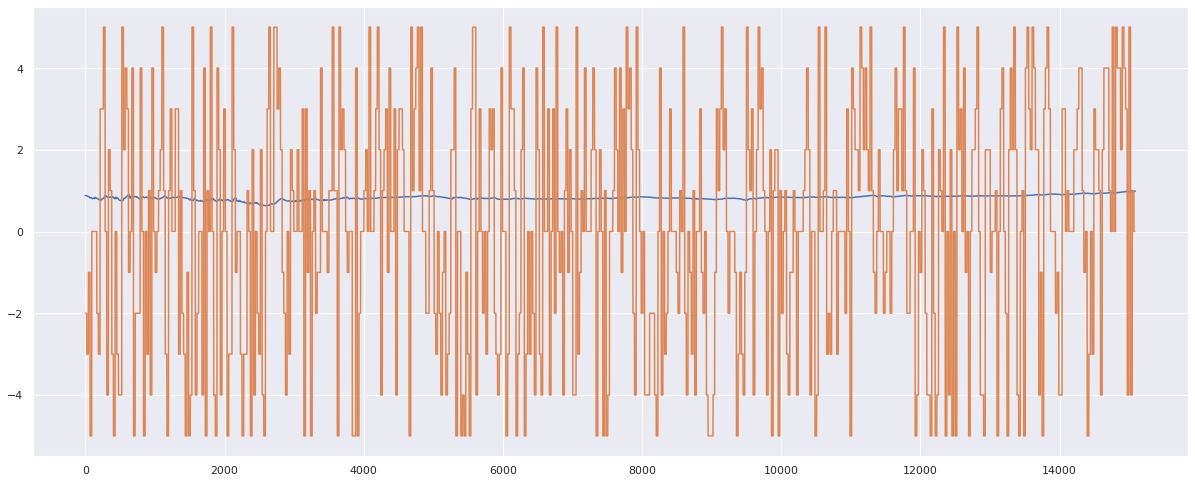

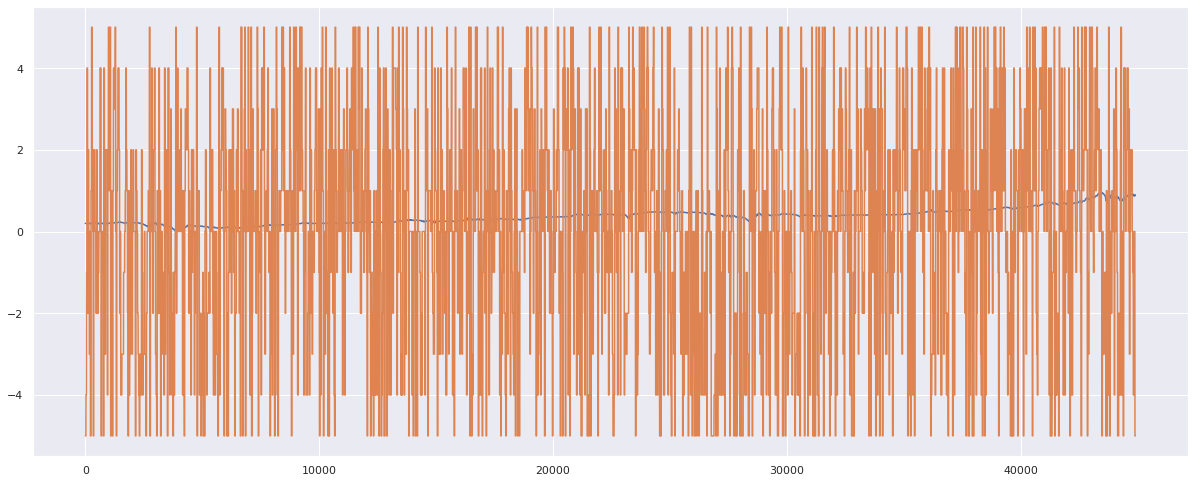

In [18]:
plt.plot(df_test.reset_index(drop=True))
plt.plot(labels_test)
plt.show()
plt.plot(df_train.reset_index(drop=True))
plt.plot(labels_train)
plt.show()

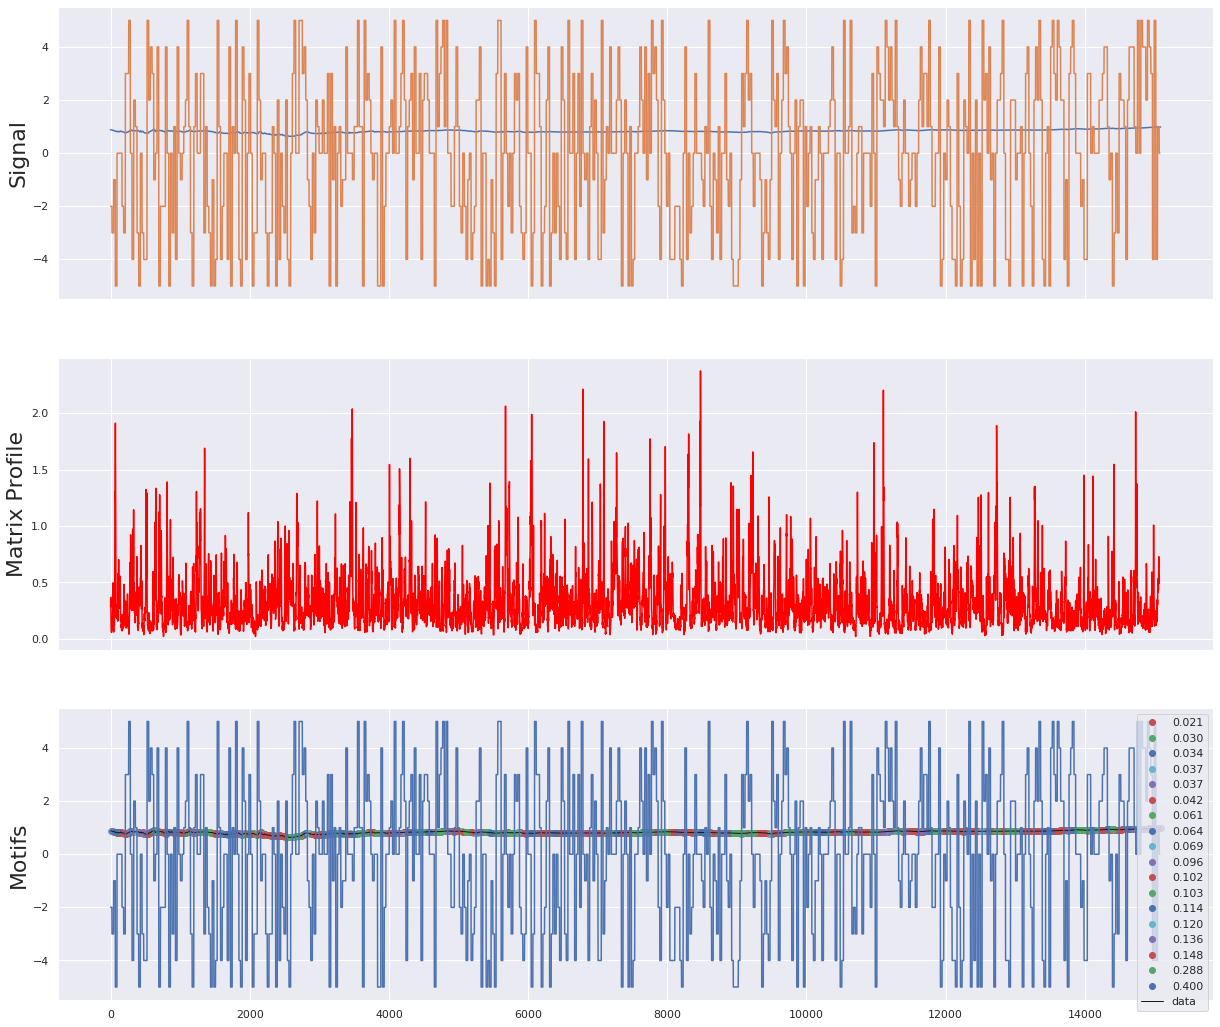

In [19]:
pattern = df_test.values.T[0]
def plot_motifs(mtfs, labels, ax):

    colori = 0
    colors = 'rgbcm'
    for ms,l in zip(mtfs,labels):
        c =colors[colori % len(colors)]
        starts = list(ms)
        ends = [min(s + m,len(pattern)-1) for s in starts]
        ax.plot(starts, pattern[starts],  c +'o',  label=l)
        ax.plot(ends, pattern[ends],  c +'o', markerfacecolor='none')
        for nn in ms:
            ax.plot(range(nn,nn+m),pattern[nn:nn+m], c , linewidth=2)
        colori += 1

    ax.plot(pattern, 'k', linewidth=1, label="data")
    ax.legend()

m=m_length
#Append np.nan to Matrix profile to enable plotting against raw data
mp = matrixProfile.scrimp_plus_plus(pattern, m_length) #6 or 32
mtfs, motif_d = motifs.motifs(pattern, mp, max_motifs=max_motifs, radius=radius)

mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

#Plot the signal data
fig, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True,figsize=(20.7,18.27))
ax1.plot(np.arange(len(pattern)),pattern, label="Test Data")
ax1.plot(labels_test)
ax1.set_ylabel('Signal', size=22)

#Plot the Matrix Profile
ax2.plot(np.arange(len(mp_adj)),mp_adj, label="Matrix Profile", color='red')
ax2.set_ylabel('Matrix Profile', size=22)

#Plot the Motifs
plot_motifs(mtfs, [f"{md:.3f}" for md in motif_d], ax3)
ax3.plot(labels_test)
ax3.set_ylabel('Motifs', size=22)
#plt.xlim((0,100))
plt.show()

In [20]:
clf = RandomForestClassifier(random_state=0)
random_grid = {'bootstrap': [True, False],
               'max_depth': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt', 'log2', None],
               'min_samples_leaf': [1, 2, 4, 6, 8, 12, 16],
               'min_samples_split': [2, 5, 10, 15, 20,25, 30, 35],
               'n_estimators': [10, 25, 50, 130, 180, 230, 450, 500, 700],
               'criterion': ['gini', 'entropy'],
               'class_weight' : ['balanced', 'balanced_subsample', None]
              }

mlp = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
#print(X_train)
#print(y_train)
#for i in range(0, X_train.shape[1]):
#    X_train[i] = np.convolve(X_train[i], [1.0, 1.0, 1.0], mode = 'same')
#X_train = np.convolve(X_train, [1.0, 1.0, 1.0], mode = 'same')
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
#splitter = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
clf = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 50, 
                         cv = splitter, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
clf.fit(X_train, y_train)

#for i in range(0, X_test.shape[1]):
#    X_test[i] = np.convolve(X_test[i], [1.0, 1.0, 1.0], mode = 'same')

y_pred = clf.predict(X_test)
score = clf.score(X_test, y_test)
conf = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
print('True')
print(y_test.values.T[0])
print('Predicted')
print(y_pred)
print('Diff')
print((np.array(y_pred).T-np.array(y_test).T)[0])
print('\n')
print(conf)
print(score)
print(report)
print(clf.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.5min finished
/home/lorenz/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


True
[-2 -2 -3 -2 -1  1 -3  0 -2 -2 -1 -2 -2 -2 -1 -4 -5 -5 -2 -3 -2 -3  0 -2
  0  0  5 -1 -2 -2 -4 -3 -2 -1  0 -1 -3 -3 -2  0  0 -1 -1  0 -2 -4 -2 -2
  0 -2 -2 -1 -1  0  3  2  0 -4  1  2  5  1  3  5 -4  5 -5  4 -3  2  0  5
  0  5  3 -5 -1  4  1  5  5  3  3  2  3  5  5  4  2  4  0  5  5  3  5  3
  2  5  3  5  1  2  4  0  4  4 -1  5  4  5  4  0  5  0 -1  3  5 -1  1  0
  2  4  0  2  2  0  4  5  5  4  3  2  1  4  5  2  3  3  5  0 -4  1  5  2
  3  3  5  1  5  2  5  4 -5  3  5  3  2  3  4  4  3 -4  2  4  5  4  4  2
  5  5  3  2  5  3  4 -5  1  3  4  0  5  0  3  0  1  5  1  5  2  0  0  2
  3 -4  4  3  4  5  4  3  2  3  3  4  2  0  3  1  4  2  2  3  2  2  1  0
  3  2  5  1  2  1  0  0  4  0  5  0  1  1  0  4  2  1  3  1  2  2  3  2
  5  2  0 -5  4  0  3  2  3  5  0  3  0  0  0  2  4  1  2  2  4  1  5  4
  4 -2 -1 -3 -4  0 -1  3 -5  0 -5 -3 -3 -4  2 -1  0 -1 -2 -5  3 -2 -2 -2
 -3 -2  0 -3 -2 -4 -5 -3  4 -1  3  0 -5 -1 -4 -2 -2  0  1 -2 -4 -1 -5 -5
 -3 -4 -4  0 -3 -1 -5  0  3 -1 -4  2  0 -1  0 

/home/lorenz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


21384
15090


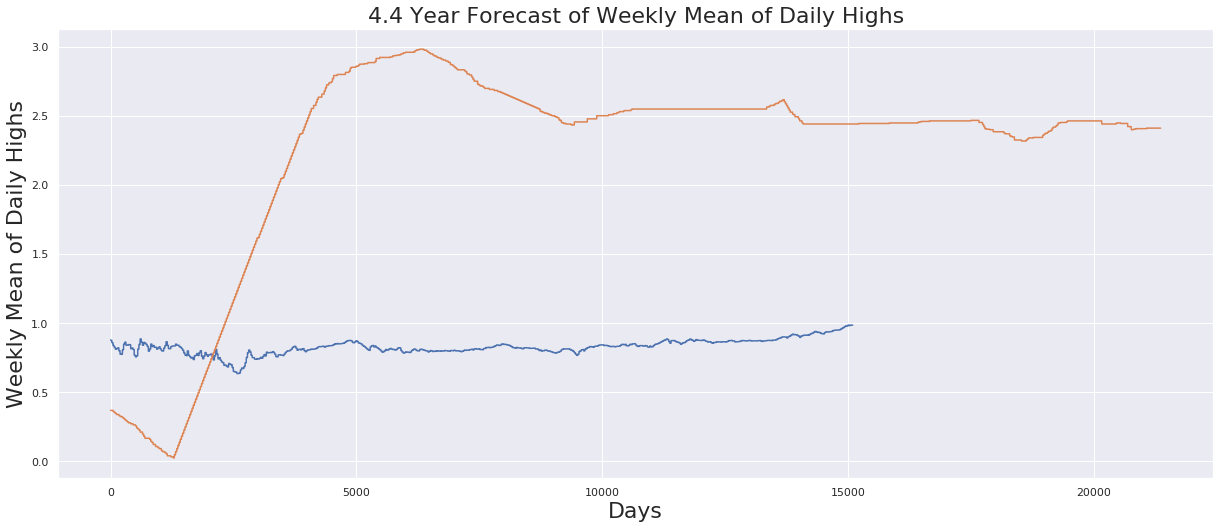

In [46]:
#Find prediction
labels_pred = []
means = []
pred = [df_train.values.T[0].mean()]
print(len(y_pred)*paa_length)
print(len(df_test.values.T[0]))
for i in range(0, len(y_pred)-1):
    if i*paa_length <= len(df_test.values.T[0]):
        means+=[df_test.values.T[0][i*paa_length:(i+1)*paa_length].mean()]*paa_length
    #else: 
    #    print(i)
    #    print(len(df_test.values.T[0]))
        
     
    if y_pred[i] == 5.0:
        pred += [pred[-1] + epsilon*0.75]*paa_length
    elif y_pred[i] == 4.0:
        pred += [pred[-1] + epsilon*0.5]*paa_length
    elif y_pred[i] == 3.0:
        pred += [pred[-1] + epsilon*0.375]*paa_length
    elif y_pred[i] == 2.0:
        pred += [pred[-1] + epsilon*0.25]*paa_length
    elif y_pred[i] == 1.0:
        pred +=[pred[-1] + epsilon*0.125]*paa_length
    elif y_pred[i] == -5.0:
        pred +=[pred[-1] - epsilon*0.75]*paa_length
    elif y_pred[i] == -4.0:
        pred +=[pred[-1] - epsilon*0.5]*paa_length
    elif y_pred[i] == -3.0:
        pred +=[pred[-1] - epsilon*0.375]*paa_length
    elif y_pred[i] == -2.0:
        pred +=[pred[-1] - epsilon*0.25]*paa_length
    elif y_pred[i] == -1.0:
        pred +=[pred[-1] - epsilon*0.125]*paa_length
    else: pred +=[pred[-1]]*paa_length
#pred = pred[:len(df_test.values.T[0])]
plt.plot(means)
plt.plot(pred)
plt.title('4.4 Year Forecast of Weekly Mean of Daily Highs', size=22)
plt.ylabel('Weekly Mean of Daily Highs', size=22)
plt.xlabel('Days',size=22)
plt.show()

In [38]:
#Simple sell and buy model with attrition
budget = 1000.0
attrition = 0.1
stock_portfolio = 0
buy_risk = 0.01#percentage of budget or portfolio
sell_risk = 0.01

df_test_denormalized = df[column].values[int(sz*0.75):] #test set

def buy(stock_portfolio, budget, risk, attrition, current_value):
    if (budget - (budget*risk + budget*risk*attrition) > 0.0 and
        budget*risk/current_value > 0
       ):
        budget -= (budget*risk + budget*risk*attrition)
        stock_portfolio += budget*risk/current_value
    return stock_portfolio, budget

def sell(stock_portfolio, budget, risk, attrition, current_value):
    if (stock_portfolio - stock_portfolio*risk > 0.0 and
        stock_portfolio*risk > 0.0
       ):
        stock_portfolio -= stock_portfolio*risk
        budget += (stock_portfolio*risk*current_value - stock_portfolio*risk*current_value*attrition)
    return stock_portfolio, budget
  
start_value = df_test_denormalized[0][0]
start_portfolio_full_budget_value = 1000.0/start_value
current_value = 0.0
portfolio_value = []
budget_value = []
actions = []
for i in range(0, len(y_pred)):
    if i*paa_length < len(df_test_denormalized):
        current_value = df_test_denormalized[i*paa_length][0]
        #print(current_value[0])
        if y_pred[i] == 5.0:
            stock_portfolio, budget = buy(stock_portfolio, budget, buy_risk*0.1, attrition, current_value)
        elif y_pred[i] == 4.0:
            stock_portfolio, budget = buy(stock_portfolio, budget, buy_risk*0.2, attrition, current_value)
            actions+=[1]*paa_length
        elif y_pred[i] == 3.0:
            stock_portfolio, budget = buy(stock_portfolio, budget, buy_risk*0.3, attrition, current_value)
            actions+=[1]*paa_length
        elif y_pred[i] == 2.0:
            stock_portfolio, budget = buy(stock_portfolio, budget, buy_risk*0.4, attrition, current_value)
            actions+=[1]*paa_length
        elif y_pred[i] == 1.0:
            stock_portfolio, budget = buy(stock_portfolio, budget, buy_risk*0.5, attrition, current_value)
            actions+=[1]*paa_length
        elif y_pred[i] == -1.0:
            stock_portfolio, budget = sell(stock_portfolio, budget, sell_risk*0.5, attrition, current_value)
            actions+=[-1]*paa_length
        elif y_pred[i] == -2.0:
            stock_portfolio, budget = sell(stock_portfolio, budget, sell_risk*0.4, attrition, current_value)
            actions+=[-1]*paa_length
        elif y_pred[i] == -3.0:
            stock_portfolio, budget = sell(stock_portfolio, budget, sell_risk*0.3, attrition, current_value)
            actions+=[-1]*paa_length
        elif y_pred[i] == -4.0:
            stock_portfolio, budget = sell(stock_portfolio, budget, sell_risk*0.2, attrition, current_value)
            actions+=[-1]*paa_length
        elif y_pred[i] == -5.0:
            stock_portfolio, budget = sell(stock_portfolio, budget, sell_risk*0.1, attrition, current_value)
            actions+=[-1]*paa_length
        else:
            #stock_portfolio, budget = sell(stock_portfolio, budget, sell_risk, attrition, current_value)
            actions+=[0]*paa_length
        portfolio_value.append(stock_portfolio*current_value)
        budget_value.append(budget)

#random buyer
random_budget = 1000.0
random_stock_portfolio = 0
random_portfolio_value = []
random_budget_value = []
for i in range(0, len(y_pred)):
    if i*paa_length < len(df_test_denormalized):
        current_value = df_test_denormalized[i*paa_length][0]
        if randrange(-3, 3, 1) > 1:
            random_stock_portfolio, random_budget = buy(random_stock_portfolio, random_budget, sell_risk, attrition, current_value)
        elif randrange(-3, 3, 1) < 1:
            random_stock_portfolio, random_budget = sell(random_stock_portfolio, random_budget, sell_risk, attrition, current_value)
        else:
            pass
        random_portfolio_value.append(random_stock_portfolio)
        random_budget_value.append(random_budget)

In [39]:
print('MOTIF BUYER')
print('start portoflio value if invested all start', start_portfolio_full_budget_value*current_value)
print('portfolio value', stock_portfolio*current_value)
print('budget', budget)
print('total', stock_portfolio*current_value + budget)
print()
print('RANDOM BUYER')
print('start portoflio value if invested all start', start_portfolio_full_budget_value*current_value)
print('portfolio value', random_stock_portfolio*current_value)
print('random budget', random_budget)
print('total', random_stock_portfolio*current_value + random_budget)

MOTIF BUYER
start portoflio value if invested all start 1070.6403385219767
portfolio value 223.20054246086187
budget 766.4501515905091
total 989.6506940513709

RANDOM BUYER
start portoflio value if invested all start 1070.6403385219767
portfolio value 145.8353392926839
random budget 738.4826139899337
total 884.3179532826176


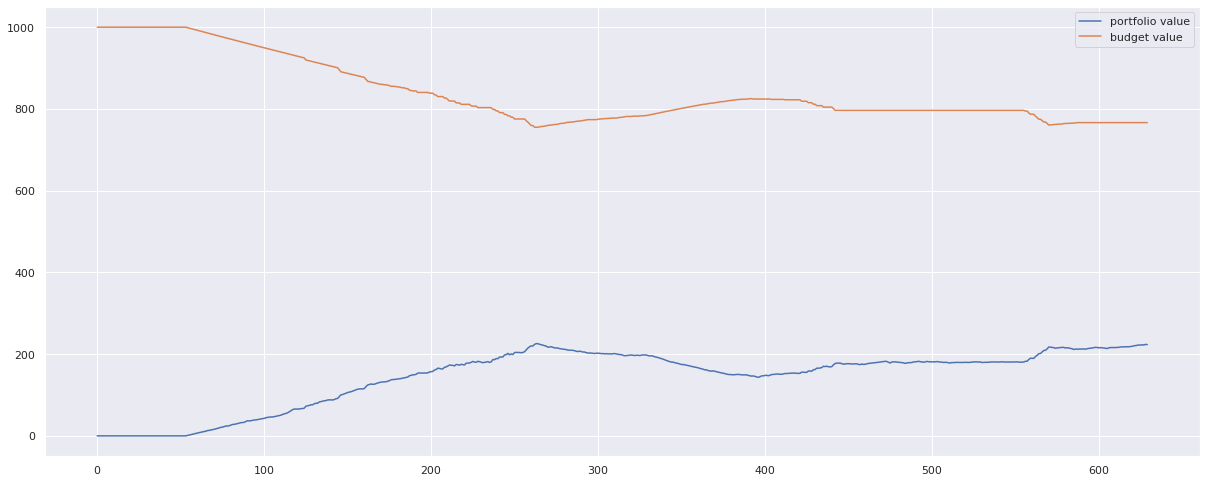

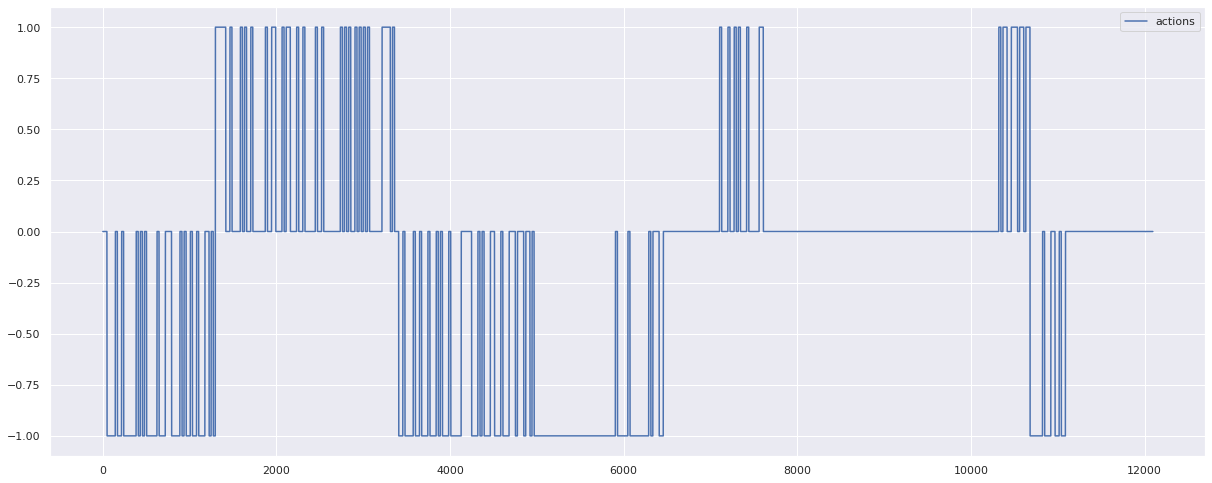

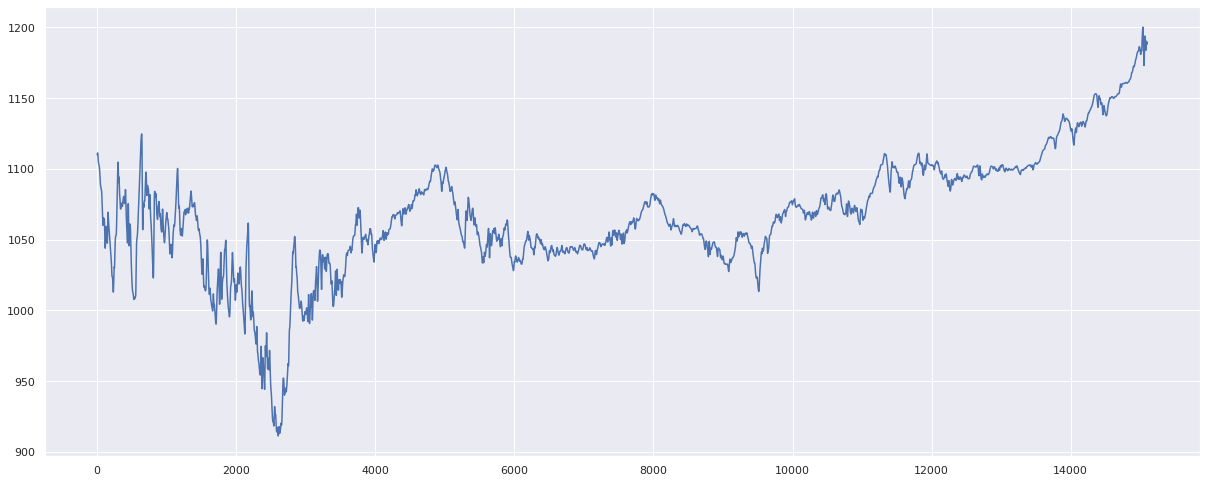

In [40]:
plt.plot(portfolio_value)
plt.plot(budget_value)
plt.legend(['portfolio value', 'budget value'])
plt.show()
plt.plot(actions)
plt.legend(['actions'])
plt.show()
plt.plot(df_test_denormalized)